In [1]:
import nltk
from os import getcwd

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples

from utils import process_tweet, build_freqs

In [3]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [4]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

In [5]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [6]:
# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


In [7]:
freqs = build_freqs(train_x, train_y)

print(f"type(freqs) = {str(type(freqs))}")
print(f"len(freqs) = {str(len(freqs.keys()))}")

type(freqs) = <class 'dict'>
len(freqs) = 11346


In [8]:
# test the function below
print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

This is an example of the processed version of the tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


# Part 1: Logistic Regression

In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Part 1.2 Cost function and Gradient

The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of the i-th training example.
* $h(z(\theta)^{(i)})$ is the model's prediction for the i-th training example.

The loss function for a single training example is
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

* All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
* Note that when the model predicts 1 ($h(z(\theta)) = 1$) and the label $y$ is also 1, the loss for that training example is 0. 
* Similarly, when the model predicts 0 ($h(z(\theta)) = 0$) and the actual label is also 0, the loss for that training example is 0. 
* However, when the model prediction is close to 1 ($h(z(\theta)) = 0.9999$) and the label is 0, the second term of the log loss becomes a large negative number, which is then multiplied by the overall factor of -1 to convert it to a positive loss value. $-1 \times (1 - 0) \times log(1 - 0.9999) \approx 9.2$ The closer the model prediction gets to 1, the larger the loss.

In [11]:
# When the model predicts close to 1
# but the actual label is 0
# the loss is a large positive value
y_hat = 0.9999 # Close to 1
y = 0
-1 * ((y * np.log(y_hat)) + ((1 - y)*np.log(1 - y_hat)))

9.210340371976294

In [12]:
# the model predicts close to zero
# but the actual label is 1
# Again the loss is large positive
y_hat = 0.0001
y = 1
-1 * ((y * np.log(y_hat)) + ((1 - y)*np.log(1 - y_hat)))

9.210340371976182

In [13]:
y_hat = 0.0001
y = 0
-1 * ((y * np.log(y_hat)) + ((1 - y)*np.log(1 - y_hat)))

0.00010000500033334732

In [14]:
y_hat = 0.9999
y = 1
-1 * ((y * np.log(y_hat)) + ((1 - y)*np.log(1 - y_hat)))

0.00010000500033334732

## Instructions: Implement gradient descent function
* The number of iterations `num_iters` is the number of times that you'll use the entire training set.
* For each iteration, you'll calculate the cost function using all training examples (there are `m` training examples), and for all features.
* Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector:  
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\ 
\theta_2 
\\ 
\vdots
\\ 
\theta_n
\end{pmatrix}$$
* $\mathbf{\theta}$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\mathbf{x_0}$ is 1).
* The 'logits', 'z', are calculated by multiplying the feature matrix 'x' with the weight vector 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
    * $\mathbf{x}$ has dimensions (m, n+1) 
    * $\mathbf{\theta}$: has dimensions (n+1, 1)
    * $\mathbf{z}$: has dimensions (m, 1)
* The prediction 'h', is calculated by applying the sigmoid to each element in 'z': $h(z) = sigmoid(z)$, and has dimensions (m,1).
* The cost function $J$ is calculated by taking the dot product of the vectors 'y' and 'log(h)'.  Since both 'y' and 'h' are column vectors (m,1), transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* The update of theta is also vectorized.  Because the dimensions of $\mathbf{x}$ are (m, n+1), and both $\mathbf{h}$ and $\mathbf{y}$ are (m, 1), we need to transpose the $\mathbf{x}$ and place it on the left in order to perform matrix multiplication, which then yields the (n+1, 1) answer we need:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

In [17]:
def gradientDescent(x, y, theta, alpha, num_iters):
    m = len(x)
    
    for i in range(0, num_iters):
        z = np.dot(x, theta)
        h = sigmoid(z)
        J = (-1/float(m)) * (np.dot(np.transpose(y), np.log(h)) + np.dot(np.transpose(1 - y), np.log(1 - h)))
        
        theta = theta - ((alpha )/float(m)) * np.dot(np.transpose(x), h - y)
        
    J = float(J)
    return J, theta

In [18]:
# Check the function
# Construct a synthetic test case using numpy PRNG functions
np.random.seed(1)
# X input is 10 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]


# Part 2: Extracting the Features

In [19]:
def extract_features(tweet, freqs):
    word_1 = process_tweet(tweet)
    
    x = np.zeros((1, 3))
    x[0, 0] = 1
    
    for word in word_1:
        x[0, 1] += freqs[(word, 1.0)] if (word, 1.0) in freqs else 0
        x[0, 2] += freqs[(word, 0.0)] if (word, 0.0) in freqs else 0
        
    assert(x.shape == (1, 3))
    return x

In [20]:
# Check your function

# test 1
# test on training data
tmp1 = extract_features(train_x[0], freqs)
print(tmp1)

[[1.00e+00 3.02e+03 6.10e+01]]


In [21]:
# test 2:
# check for when the words are not in the freqs dictionary
tmp2 = extract_features('blorb bleeeeb bloooob', freqs)
print(tmp2)

[[1. 0. 0.]]


## Pretraining the Model

In [22]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :] = extract_features(train_x[i], freqs)
    
Y = train_y

J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.24216529.
The resulting vector of weights is [7e-08, 0.0005239, -0.00055517]


In [23]:
def predict_tweet(tweet, freqs, theta):
    x = extract_features(tweet, freqs)
    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred

In [24]:
# Feel free to check the sentiment of your own tweet below
my_tweet = 'I am learning :)'
predict_tweet(my_tweet, freqs, theta)

array([[0.81636424]])

## Check on Test Set

In [31]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    
    y_hat = []
    for tweet in test_x:
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if(y_pred > 0.5):
            y_hat.append(1.0)
        else:
            y_hat.append(0.0)
            
    accuracy = np.sum(y_hat == np.squeeze(test_y))/float(len(test_x))
    return accuracy

In [32]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9950


## Error Analysis

In [33]:
print('Label Predicted Tweet')
for x, y in zip(test_x, test_y):
    y_hat = predict_tweet(x, freqs, theta)
    
    if(np.abs(y -( y_hat > 0.5)) > 0):
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: @jaredNOTsubway @iluvmariah @Bravotv Then that truly is a LATERAL move! Now, we all know the Queen Bee is UPWARD BOUND : ) #MovingOnUp
THE PROCESSED TWEET IS: ['truli', 'later', 'move', 'know', 'queen', 'bee', 'upward', 'bound', 'movingonup']
1	0.49996890	b'truli later move know queen bee upward bound movingonup'
THE TWEET IS: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
THE PROCESSED TWEET IS: ['sure', 'would', 'good', 'thing', '4', 'bottom', 'dare', '2', 'say', '2', 'miss', 'b', 'im', 'gonna', 'stubborn', 'mouth', 'soap', 'nothavingit', ':p']
1	0.48622857	b'sure would good thing 4 bottom dare 2 say 2 miss b im gonna stubborn mouth soap nothavingit :p'
THE TWEET IS: I'm playing Brain Dots : ) #BrainDots
http://t.co/UGQzOx0huu
THE PROCESSED TWEET IS: ["i'm", 'play', 'brain', 'dot', 'braindot']
1	0.48370665	b"i'm play brain dot braindot"
THE TWEET IS: I'm p

In [34]:
# Feel free to change the tweet below
my_tweet = 'This is a ridiculously bright movie. The plot was terrible and I was sad until the ending!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['ridicul', 'bright', 'movi', 'plot', 'terribl', 'sad', 'end']
[[0.48139087]]
Negative sentiment


In [4]:
def sigmoid(z): 
    h = 1 / (1 + np.exp(-z))
    return h

In [7]:
import matplotlib.pyplot as plt

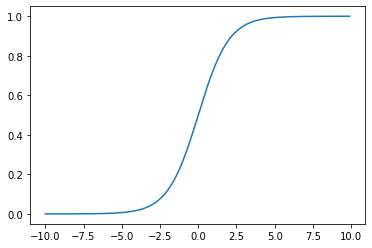